### Importing Libraries

In [100]:
import requests
import pandas as pd
import re
import string
import seaborn as sns

### Scraping Tweets from Twitter

In [ ]:
import snscrape.modules.twitter as sntwitter
import pandas as pd

query = "(Reliance Industries) until:2020-07-30 since:2020-05-1"
Tweets = []
limit = 20000


for tweet in sntwitter.TwitterSearchScraper(query).get_items():
    if len(Tweets) == limit:
        break
    if tweet.lang == 'en':
        date = str(tweet.date).split(" ")[0]
        time = str(tweet.date).split(" ")[1].split("+")[0] 
        Tweets.append([date, time , tweet.content])
        
        
df = pd.DataFrame(Tweets, columns=['Date', 'Time', 'Tweet'])
print(df)

# to save to csv
# df.to_csv('tweets.csv')

In [37]:
df

,Date,User,Tweet
0,2020-07-29,23:30:21,"Reliance Industries to offer over Rs. 24,000 c..."
1,2020-07-29,23:29:18,Reliance Industries Falls Most In Over 2 Month...
2,2020-07-29,22:30:33,ETTelecom | Brokerages expect Reliance to repo...
3,2020-07-29,22:00:28,ETTelecom | Brokerages expect Reliance to repo...
4,2020-07-29,20:16:21,Reliance Industries: Update and some wishful t...
...,...,...,...
15175,2020-05-01,00:36:36,TCS snatches most-profitable tag from Reliance...
15176,2020-05-01,00:34:36,Reliance Industries https://t.co/m38p7JUcN9
15177,2020-05-01,00:32:16,"After Facebook, Reliance Industries in talks w..."
15178,2020-05-01,00:24:42,Reliance Industries donates 500 cr to PM CARES...


### Cleaning our tweets

In [84]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [86]:
def remove_punct(text):
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    text = re.sub('\n' , "", text)
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    emoji_pattern.sub(r'', text) # no emoji
    return text

df['Tweet'] = df['Tweet'].apply(lambda x: remove_punct(x))
df.head(10)

,Date,User,Tweet
0,2020-07-29,23:30:21,Reliance Industries to offer over Rs crore fo...
1,2020-07-29,23:29:18,Reliance Industries Falls Most In Over Months...
2,2020-07-29,22:30:33,ETTelecom Brokerages expect Reliance to repor...
3,2020-07-29,22:00:28,ETTelecom Brokerages expect Reliance to repor...
4,2020-07-29,20:16:21,Reliance Industries Update and some wishful th...
5,2020-07-29,20:14:07,Results Tomorrow th July StockMarket Nifty Nif...
6,2020-07-29,19:57:24,Hope we had been AatmaNirbhar on Rafale tooYea...
7,2020-07-29,19:30:47,Reliance Industries overtakes Exxon to become ...
8,2020-07-29,19:15:20,Most expensive share in India is MRF LTD Madr...
9,2020-07-29,19:14:38,Results Update RelianceIndustriesHDFCDaburTorr...


### Sentiment Analysis using Flair Library
* This model splits the text into character-level tokens and uses the DistilBERT model to make predictions.
* The advantage of working at the character-level (as opposed to word-level) is that words that the network has never seen before can still be assigned a sentiment.
* DistilBERT is distilled version of the powerful BERT transformer model which in short means it is a small model (only 66 million parameters) and is still super powerful.

In [90]:
import flair
sentiment_model = flair.models.TextClassifier.load('en-sentiment')

2022-08-04 17:23:41,284 loading file C:\Users\LENOVO\.flair\models\sentiment-en-mix-distillbert_4.pt


In [91]:
probs_list = []
sentiment_list = []

def predict(Tweet):
        for i in range(len(Tweet)):
                sentence = flair.data.Sentence(Tweet[i])
                sentiment_model.predict(sentence)
                
                probs = sentence.labels[0].score
                sentiment = sentence.labels[0].value
        
                probs_list.append(probs)
                sentiment_list.append(sentiment)
        
        # data = {"Probaility": probs_list,
        #         "Sentiment": sentiment_list}
        return probs_list , sentiment_list

In [92]:
prob_list , sent_list = predict(df['Tweet'])

In [93]:
df['Probability'] = probs_list
df['Sentiment'] = sent_list

In [94]:
df.head()

,Date,User,Tweet,Probability,Sentiment
0,2020-07-29,23:30:21,Reliance Industries to offer over Rs crore fo...,0.980158,POSITIVE
1,2020-07-29,23:29:18,Reliance Industries Falls Most In Over Months...,0.995565,NEGATIVE
2,2020-07-29,22:30:33,ETTelecom Brokerages expect Reliance to repor...,0.898588,NEGATIVE
3,2020-07-29,22:00:28,ETTelecom Brokerages expect Reliance to repor...,0.933012,NEGATIVE
4,2020-07-29,20:16:21,Reliance Industries Update and some wishful th...,0.994781,NEGATIVE


In [99]:
df['Sentiment'].value_counts()

NEGATIVE    7831
POSITIVE    7349
Name: Sentiment, dtype: int64

### Using Yahoo Finance

In [38]:
import yfinance as yf

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15180 entries, 0 to 15179
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    15180 non-null  object
 1   User    15180 non-null  object
 2   Tweet   15180 non-null  object
dtypes: object(3)
memory usage: 355.9+ KB


In [66]:
df.Date = pd.to_datetime(df['Date'])

In [71]:
df.Date.min(), df.Date.max().strftime('%Y-%m-%d')

(Timestamp('2020-05-01 00:00:00'), '2020-07-29')

In [76]:
Reliance = yf.Ticker("RELIANCE.NS")
Reliance_stock = Reliance.history(
    start = (df.Date.min()).strftime('%Y-%m-%d'),
    end = df.Date.max().strftime('%Y-%m-%d'),
    interval='1d'
).reset_index()

In [77]:
Reliance_stock

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2020-05-04,1416.585187,1441.178689,1394.401855,1411.863281,24670336,0.0,0
1,2020-05-05,1430.062518,1454.951079,1423.668210,1436.899414,20723079,0.0,0
2,2020-05-06,1440.195079,1460.804444,1421.995884,1436.997925,18685710,0.0,0
3,2020-05-07,1431.341286,1489.037709,1421.503982,1482.446655,23087436,0.0,0
4,2020-05-08,1519.877872,1554.210366,1512.106342,1536.404785,38887255,0.0,0
...,...,...,...,...,...,...,...,...
56,2020-07-22,1976.641313,2003.554735,1954.412772,1997.573975,27584518,0.0,0
57,2020-07-23,1997.523996,2073.031093,1984.964425,2051.201416,26921017,0.0,0
58,2020-07-24,2051.400825,2156.064133,2051.201515,2139.268066,55655668,0.0,0
59,2020-07-27,2171.813517,2191.749385,2121.076587,2149.285889,37060665,0.0,0


In [80]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'Price')

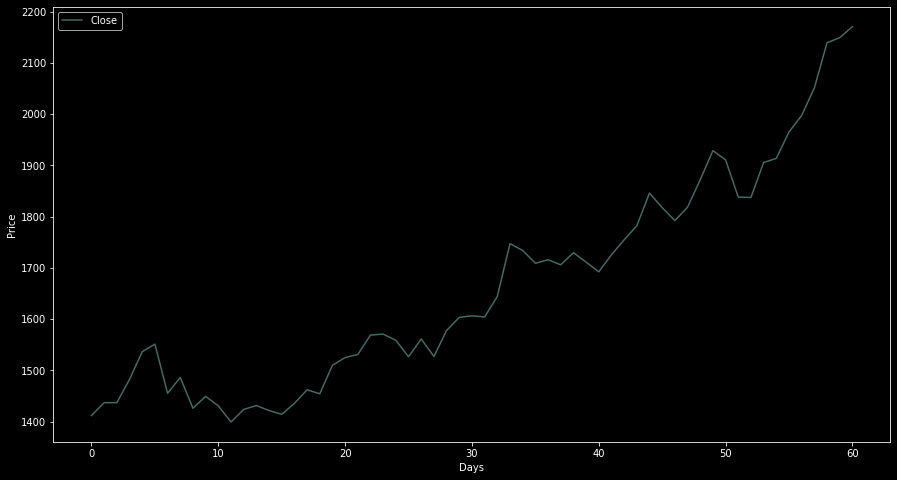

In [103]:
Reliance_stock[['Close']].plot(figsize = (15, 8), alpha = 0.5)
plt.xlabel("Days")
plt.ylabel("Price")

In [107]:
import datetime

In [148]:
df['Date'].min()

Timestamp('2020-05-01 00:00:00')

In [127]:
df['Date'][5950]

Timestamp('2020-06-30 00:00:00')

In [128]:
my_date_days = df['Date'][5950] + datetime.timedelta(days = 1)
print(my_date_days)

2020-07-01 00:00:00


In [156]:
df['Date'].min() , str(df['Date'][15179]).split(" ")[0]

(Timestamp('2020-05-01 00:00:00'), '2020-05-01')

In [264]:
meh = df['Date'].value_counts(sort = False)
D_C = pd.DataFrame(meh)
D_C = D_C.reset_index().rename(columns={'index': 'Date', "Date": "Count"})
D_C

,Date,Count
0,2020-07-29,178
1,2020-07-28,154
2,2020-07-27,188
3,2020-07-26,96
4,2020-07-25,126
...,...,...
85,2020-05-05,97
86,2020-05-04,319
87,2020-05-03,73
88,2020-05-02,78


In [265]:
Count_list = list(D_C["Count"])

In [266]:
i = 0
j = 0
average = []

while i != len(df):
    sum = df['Probability'][i : i + Count_list[j]].sum()
    average.append(sum / Count_list[j])
    i += Count_list[j]
    j += 1
average    

[0.88732291272517,
 0.8797393220585662,
 0.835088516486452,
 0.8888167360176643,
 0.8751993699679299,
 0.8803623946605886,
 0.8772546217098074,
 0.8937973500472571,
 0.8992759452925788,
 0.8930399941874074,
 0.9027032158146165,
 0.8850871467072031,
 0.8814902001792945,
 0.9043703071457555,
 0.8808095746757553,
 0.8862911644266612,
 0.8783212644438589,
 0.8795251909530524,
 0.8954805997110182,
 0.8871401847625265,
 0.887510746717453,
 0.8744003310799598,
 0.8892796644940972,
 0.8627308237500586,
 0.8362623929977417,
 0.8629748060042599,
 0.8472512244708895,
 0.8855360089722326,
 0.8823933365444342,
 0.8581447587771849,
 0.913225947199641,
 0.8617058558897539,
 0.9214767628245883,
 0.8678746137066163,
 0.8809456626574198,
 0.8817313141618038,
 0.8629760925931141,
 0.8921955592363212,
 0.870897665472314,
 0.891745563442185,
 0.8563142086201083,
 0.8645862994194031,
 0.8659229626258215,
 0.8799507292834196,
 0.890317164773318,
 0.8442997488760411,
 0.8719691102727881,
 0.8572561101913452,


In [267]:
D_C['Average_Probability'] = average

In [268]:
D_C

,Date,Count,Average_Probability
0,2020-07-29,178,0.887323
1,2020-07-28,154,0.879739
2,2020-07-27,188,0.835089
3,2020-07-26,96,0.888817
4,2020-07-25,126,0.875199
...,...,...,...
85,2020-05-05,97,0.850521
86,2020-05-04,319,0.882814
87,2020-05-03,73,0.867574
88,2020-05-02,78,0.919108


In [269]:
# Reverse rows using iloc() Function
D_C_N = D_C[::-1].reset_index(drop = True)

In [270]:
D_C_N

,Date,Count,Average_Probability
0,2020-05-01,220,0.889981
1,2020-05-02,78,0.919108
2,2020-05-03,73,0.867574
3,2020-05-04,319,0.882814
4,2020-05-05,97,0.850521
...,...,...,...
85,2020-07-25,126,0.875199
86,2020-07-26,96,0.888817
87,2020-07-27,188,0.835089
88,2020-07-28,154,0.879739


In [279]:
D_C_A = D_C_N.sort_values("Count", ascending = False)

In [280]:
D_C_A = D_C_A[0 : 61] 

In [281]:
D_C_A = D_C_A.reset_index(drop = True)
D_C_A

,Date,Count,Average_Probability
0,2020-07-15,1343,0.880810
1,2020-06-19,826,0.856314
2,2020-06-05,429,0.833995
3,2020-05-08,422,0.878092
4,2020-06-22,381,0.892196
...,...,...,...
56,2020-06-16,99,0.879951
57,2020-05-05,97,0.850521
58,2020-07-26,96,0.888817
59,2020-07-18,92,0.885087


In [302]:
D_C_A = D_C_A.sort_values(by = 'Date')

In [303]:
D_C_A = D_C_A.reset_index(drop = True)
D_C_A

,Date,Count,Average_Probability
0,2020-05-01,220,0.889981
1,2020-05-04,319,0.882814
2,2020-05-05,97,0.850521
3,2020-05-07,147,0.897225
4,2020-05-08,422,0.878092
...,...,...,...
56,2020-07-25,126,0.875199
57,2020-07-26,96,0.888817
58,2020-07-27,188,0.835089
59,2020-07-28,154,0.879739


In [304]:
Close_Price_list = []
def Close_Price(D_C_A):
    for i in range(0 , 61):
        Start_date = str(D_C_A['Date'][i]).split(' ')[0]
        End_Date = str(D_C_A['Date'][i] + datetime.timedelta(days = 5)).split(" ")[0]
        C_P = Reliance.history(start = Start_date , end = End_Date, period = '1d')
        Close_Price_list.append(C_P['Close'][0])
    return Close_Price_list

In [305]:
C_P_list = Close_Price(D_C_A)

In [307]:
D_C_A["Close_Price"] = C_P_list

In [309]:
D_C_A.head()

,Date,Count,Average_Probability,Close_Price
0,2020-05-01,220,0.889981,1411.863281
1,2020-05-04,319,0.882814,1411.863281
2,2020-05-05,97,0.850521,1436.899414
3,2020-05-07,147,0.897225,1482.446655
4,2020-05-08,422,0.878092,1536.404785


In [311]:
D_C_A['Sentiment_Score'] = D_C_A['Average_Probability'] * D_C_A['Close_Price']

In [312]:
D_C_A.head()

,Date,Count,Average_Probability,Close_Price,Sentiment_Score
0,2020-05-01,220,0.889981,1411.863281,1256.531322
1,2020-05-04,319,0.882814,1411.863281,1246.412930
2,2020-05-05,97,0.850521,1436.899414,1222.112871
3,2020-05-07,147,0.897225,1482.446655,1330.088928
4,2020-05-08,422,0.878092,1536.404785,1349.105152


In [361]:
D_C_A['Count'].sum() , len(D_C_A) , (D_C_A['Close_Price'] - D_C_A['Sentiment_Score']).sum() / D_C_A['Count'].sum()

(13064, 61, 0.9603000556970742)

In [362]:
Quant = (D_C_A['Close_Price'] - D_C_A['Sentiment_Score']).sum() / D_C_A['Count'].sum()
Quant

0.9603000556970742

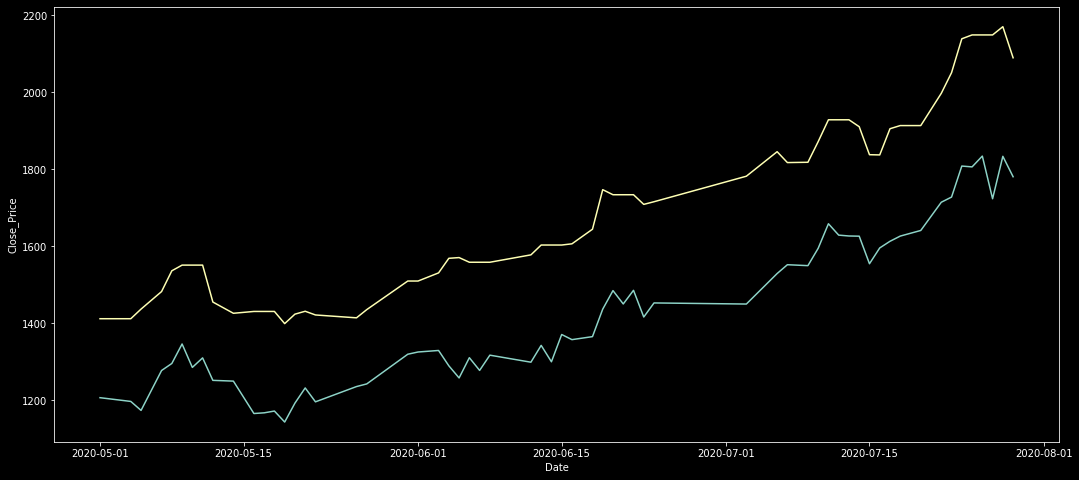

In [363]:
plt.figure(figsize = (18, 8))
plt.plot(D_C_A['Date'] ,D_C_A['Sentiment_Score'] * Quant)
plt.plot(D_C_A['Date'] ,D_C_A['Close_Price'])
plt.xlabel("Date")
plt.ylabel("Close_Price")

plt.show()

In [324]:
Open_Price_list = []
def Open_Price(D_C_A):
    for i in range(0 , 61):
        Start_date = str(D_C_A['Date'][i]).split(' ')[0]
        End_Date = str(D_C_A['Date'][i] + datetime.timedelta(days = 5)).split(" ")[0]
        C_P = Reliance.history(start = Start_date , end = End_Date, period = '1d')
        Open_Price_list.append(C_P['Open'][0])
    return Open_Price_list

O_P_list = Open_Price(D_C_A)
D_C_A["Open_Price"] = O_P_list

In [325]:
D_C_A.head()

,Date,Count,Average_Probability,Close_Price,Sentiment_Score,Open_Price
0,2020-05-01,220,0.889981,1411.863281,1256.531322,1416.585187
1,2020-05-04,319,0.882814,1411.863281,1246.412930,1416.585187
2,2020-05-05,97,0.850521,1436.899414,1222.112871,1430.062518
3,2020-05-07,147,0.897225,1482.446655,1330.088928,1431.341286
4,2020-05-08,422,0.878092,1536.404785,1349.105152,1519.877872


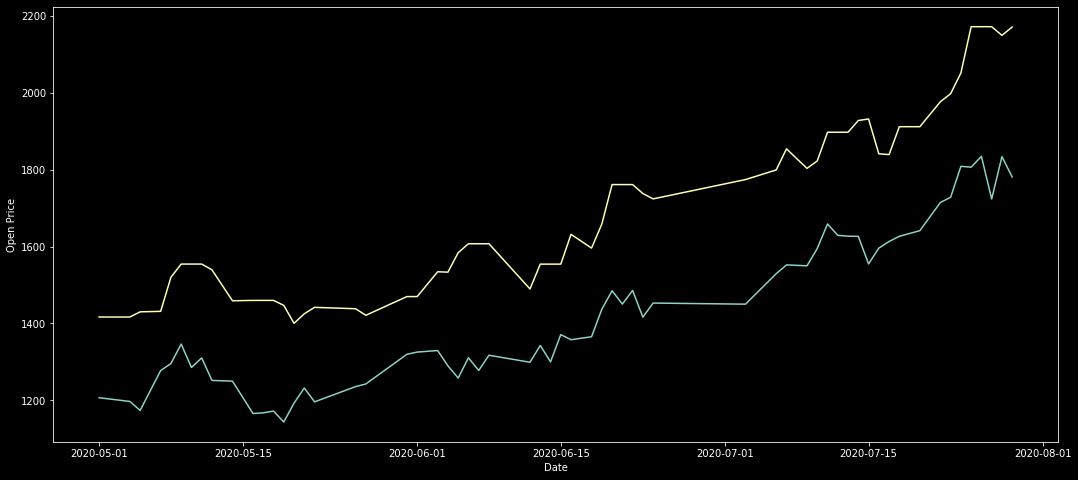

In [366]:
plt.figure(figsize = (18, 8))
plt.plot(D_C_A['Date'] ,D_C_A['Sentiment_Score'] * Quant)
plt.plot(D_C_A['Date'] ,D_C_A['Open_Price'])
plt.xlabel("Date")
plt.ylabel("Open Price")

plt.show()